**This notebook is an exercise in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/stochastic-gradient-descent).**

---


# Introduction #

In this exercise you'll train a neural network on the *Fuel Economy* dataset and then explore the effect of the learning rate and batch size on SGD.

When you're ready, run this next cell to set everything up!

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
from learntools.deep_learning_intro.dltools import animate_sgd
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex3 import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_28/3305082411.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In the *Fuel Economy* dataset your task is to predict the fuel economy of an automobile given features like its type of engine or the year it was made. 

First load the dataset by running the cell below.

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from warnings import simplefilter
simplefilter('ignore')

fuel = pd.read_csv('../input/dl-course-data/fuel.csv')

X = fuel.copy()
# Remove target
y = X.pop('FE')

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)
y = np.log(y) # log transform target instead of standardizing

input_shape = [X.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [50]


In [3]:
fuel.head()

,EngDispl,NumCyl,Transmission,FE,AirAspirationMethod,NumGears,TransLockup,TransCreeperGear,DriveDesc,IntakeValvePerCyl,ExhaustValvesPerCyl,CarlineClassDesc,VarValveTiming,VarValveLift
0,4.7,8,AM6,28.0198,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
1,4.7,8,M6,25.6094,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
2,4.2,8,M6,26.8000,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,2Seaters,1,0
3,4.2,8,AM6,25.0451,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,2Seaters,1,0
4,5.2,10,AM6,24.8000,NaturallyAspirated,6,0,0,AllWheelDrive,2,2,2Seaters,1,0


In [11]:
X

array([[ 0.91364344,  1.06800546,  0.52414834, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.91364344,  1.06800546,  0.52414834, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53059417,  1.06800546,  0.52414834, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.23550436,  0.01521646,  0.52414834, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23550436,  0.01521646,  0.52414834, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68381388,  1.06800546,  0.52414834, ...,  0.        ,
         0.        ,  0.        ]])

Take a look at the data if you like. Our target in this case is the `'FE'` column and the remaining columns are the features.

In [9]:
y.head()

0    3.332911
1    3.242959
2    3.288402
3    3.220678
4    3.210844
Name: FE, dtype: float64

In [12]:
# missing_values 
fuel.isnull().sum()

EngDispl               0
NumCyl                 0
Transmission           0
FE                     0
AirAspirationMethod    0
NumGears               0
TransLockup            0
TransCreeperGear       0
DriveDesc              0
IntakeValvePerCyl      0
ExhaustValvesPerCyl    0
CarlineClassDesc       0
VarValveTiming         0
VarValveLift           0
dtype: int64

In [13]:
# Uncomment to see original data
fuel.head()
# Uncomment to see processed features
pd.DataFrame(X[:10,:]).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.913643,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.913643,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.530594,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.530594,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.296693,2.120794,0.524148,-1.458464,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Run the next cell to define the network we'll use for this task.

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

# 1) Add Loss and Optimizer

Before training the network we need to define the loss and optimizer we'll use. Using the model's `compile` method, add the Adam optimizer and MAE loss.

In [15]:
# YOUR CODE HERE
model.compile(optimizer = 'adam',loss = 'mae')

# Check your answer
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#q_1.hint()
#q_1.solution()

# 2) Train Model

Once you've defined the model and compiled it with a loss and optimizer you're ready for training. Train the network for 200 epochs with a batch size of 128. The input data is `X` with target `y`.

In [20]:
# YOUR CODE HERE
history = model.fit(X, y, batch_size = 128, epochs = 200)

# Check your answer
q_2.check()

Epoch 1/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 2/200
9/9 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 4/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 5/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 6/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 8/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 9/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 10/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 11/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 12/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 13/200
9/9 [==============================] - 0s 4ms/st

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#q_2.hint()
#q_2.solution()

The last step is to look at the loss curves and evaluate the training. Run the cell below to get a plot of the training loss.

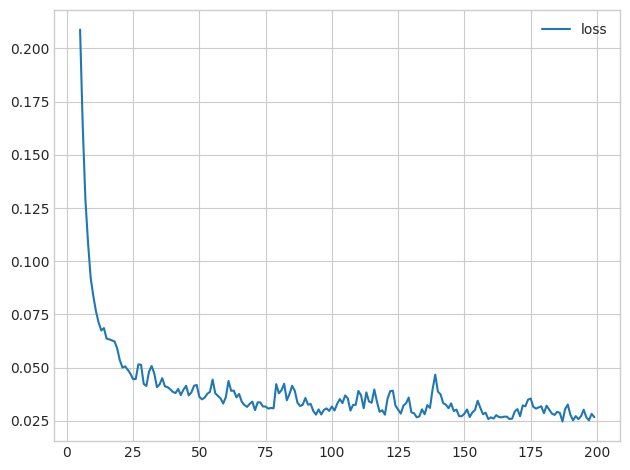

In [17]:
import pandas as pd

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot();

# 3) Evaluate Training

If you trained the model longer, would you expect the loss to decrease further?

In [18]:
# View the solution (Run this cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

This depends on how the loss has evolved during training: if the learning curves have levelled off, there won't usually be any advantage to training for additional epochs.  Conversely, if the loss appears to still be decreasing, then training for longer could be advantageous.

With the learning rate and the batch size, you have some control over:
- How long it takes to train a model
- How noisy the learning curves are
- How small the loss becomes

To get a better understanding of these two parameters, we'll look at the linear model, our ppsimplest neural network. Having only a single weight and a bias, it's easier to see what effect a change of parameter has.

The next cell will generate an animation like the one in the tutorial. Change the values for `learning_rate`, `batch_size`, and `num_examples` (how many data points) and then run the cell. (It may take a moment or two.) Try the following combinations, or try some of your own:

| `learning_rate` | `batch_size` | `num_examples` |
|-----------------|--------------|----------------|
| 0.05            | 32           | 256            |
| 0.05            | 2            | 256            |
| 0.05            | 128          | 256            |
| 0.02            | 32           | 256            |
| 0.2             | 32           | 256            |
| 1.0             | 32           | 256            |
| 0.9             | 4096         | 8192           |
| 0.99            | 4096         | 8192           |

In [22]:
# YOUR CODE HERE: Experiment with different values for the learning rate, batch size, and number of examples
learning_rate = 0.05
batch_size = 32
num_examples = 256

animate_sgd(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_examples=num_examples,
    # You can also change these, if you like
    steps=100, # total training steps (batches seen)
    true_w=6.0, # the slope of the data
    true_b=4.0, # the bias of the data
)

# 4) Learning Rate and Batch Size

What effect did changing these parameters have? After you've thought about it, run the cell below for some discussion.

In [23]:
# View the solution (Run this cell to receive credit!)
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 


You probably saw that smaller batch sizes gave noisier weight updates and loss curves. This is because each batch is a small *sample* of data and smaller samples tend to give noisier estimates. Smaller batches can have an "averaging" effect though which can be beneficial.

Smaller learning rates make the updates smaller and the training takes longer to converge. Large learning rates can speed up training, but don't "settle in" to a minimum as well. When the learning rate is too large, the training can fail completely. (Try setting the learning rate to a large value like 0.99 to see this.)


# Keep Going #

Learn how to [**improve your model's performance**](https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting) by tuning capacity or adding an early stopping callback.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*